In [1]:
# kütüphane importları

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

In [2]:
# Veri analizi

df = pd.read_csv('../input/amazon-fine-food-reviews/Reviews.csv')
def check_df(df, head=5):
    print("### Shape ###"); print(df.shape)
    print("\n### Types ###"); print(df.dtypes)
    print(f"\n### Head ({head}) ###"); print(df.head(head))
    print(f"\n### Tail ({head}) ###"); print(df.tail(head))
    print("\n### Missing Values ###"); print(df.isnull().sum())
    print(f"\nAny Missing? {df.isnull().any().any()}")
    print(f"\nDuplicate Rows: {df.duplicated().sum()}")
    
check_df(df)

### Shape ###
(568454, 10)

### Types ###
Id                         int64
ProductId                 object
UserId                    object
ProfileName               object
HelpfulnessNumerator       int64
HelpfulnessDenominator     int64
Score                      int64
Time                       int64
Summary                   object
Text                      object
dtype: object

### Head (5) ###
   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0            

In [3]:
df = df.head(500)
print(df.shape)

(500, 10)


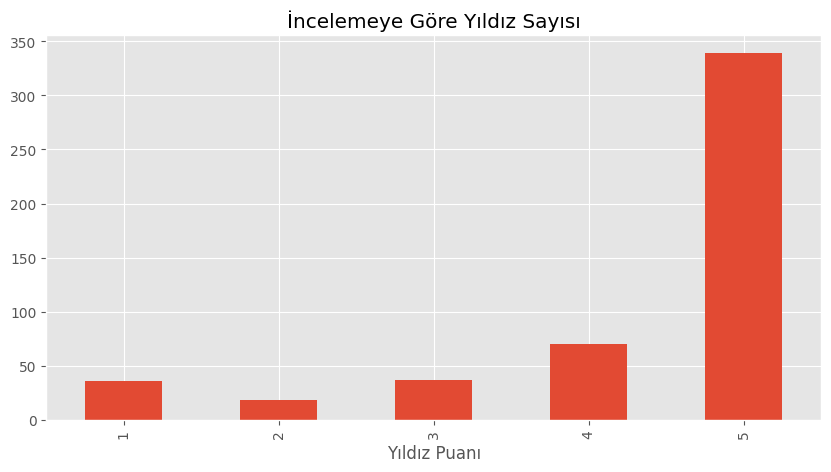

In [4]:
# İncelemeye Göre Yıldız Sayısı Görselleştirme

ax = df['Score'].value_counts().sort_index() \
    .plot(kind='bar',
          title='İncelemeye Göre Yıldız Sayısı',
          figsize=(10, 5))
ax.set_xlabel('Yıldız Puanı')
plt.show()

In [5]:
# dataFrame'den metin örneği görüntüleme

example = df["Text"][50]
print(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [6]:
# metni NLTK ile kelime token'larına ayırma

tokens = nltk.word_tokenize(example)
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [7]:
# NLTK ile kelimelere Part-of-Speech (POS) etiketleme

nltk.download('averaged_perceptron_tagger_eng')
tagged = nltk.pos_tag(tokens)
tagged[:10]

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

In [8]:
# NLTK ile metindeki varlık isimlerini tanıma

nltk.download('maxent_ne_chunker_tab')
nltk.download('words')
entities = nltk.ne_chunk(tagged)
entities.pprint()

[nltk_data] Downloading package maxent_ne_chunker_tab to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package maxent_ne_chunker_tab is already up-to-date!
[nltk_data] Downloading package words to /usr/share/nltk_data...
[nltk_data]   Package words is already up-to-date!


(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


# VADER
* Bu yaklaşım, cümledeki tüm kelimeleri dikkate alır. Her kelimeye pozitif, nötr veya negatif bir değer atar. Daha sonra bu değerleri birleştirerek bir denklem oluşturur ve ifadenin genel olarak pozitif, negatif ya da nötr olduğunu belirler.

* Bu yaklaşım doğal dilde çok önemli olan kelimeler arasındaki ilişkileri hesaba katmaz.

In [9]:
# NLTK VADER ile duygu analizi başlatma

from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [10]:
sia.polarity_scores("I hate you")

{'neg': 0.787, 'neu': 0.213, 'pos': 0.0, 'compound': -0.5719}

In [11]:
sia.polarity_scores("I love u darling. U are so amazing!")

{'neg': 0.0, 'neu': 0.139, 'pos': 0.861, 'compound': 0.9244}

In [12]:
sia.polarity_scores(example)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [13]:
# tüm dataFrame üzerinde duygu analizi uygulama

results = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    myid = row['Id']
    results[myid] = sia.polarity_scores(text)

  0%|          | 0/500 [00:00<?, ?it/s]

In [14]:
# duygu analizi sonuçlarını DataFrame'e dönüştürme ve birleştirme

vaders = pd.DataFrame(results).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how='left')

In [15]:
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


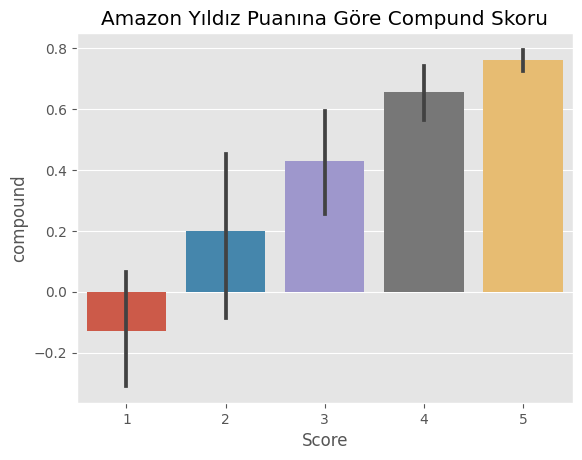

In [16]:
# Amazon Yıldız Puanına Göre Compund Skoru Görselleştirmesi

ax = sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title('Amazon Yıldız Puanına Göre Compund Skoru')
plt.show()

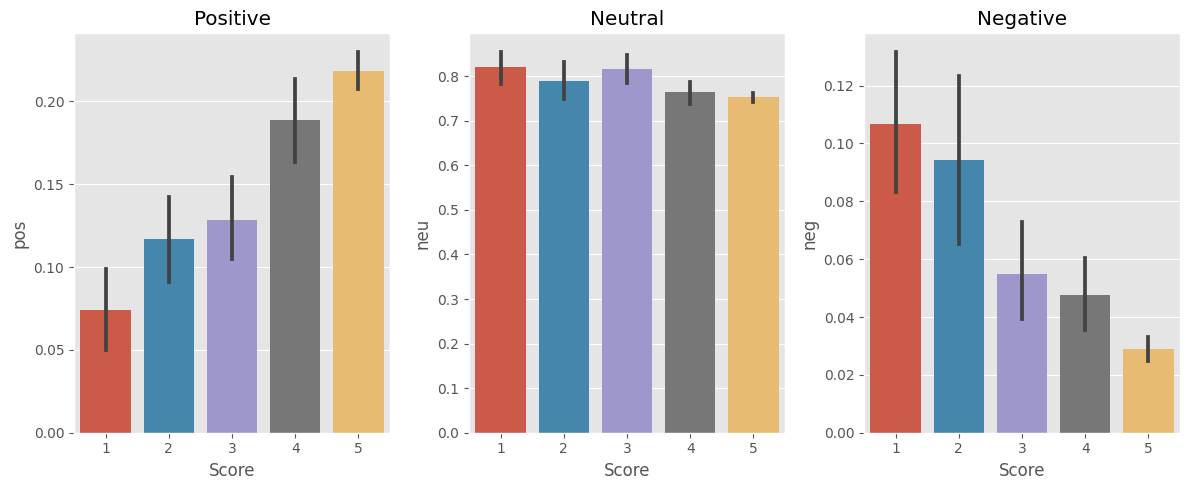

In [17]:
# duygu skorlarının puanlara göre dağılımını görselleştirme

fig, axs = plt.subplots(1, 3, figsize=(12, 5))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

In [18]:
# Import işlemleri

from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [19]:
# model tanımlama

MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

2025-09-29 08:43:17.875893: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759135397.918313     127 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759135397.926821     127 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [20]:
# RoBERTa modeli ile duygu analizi ve Softmax skorları hesaplama

encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.97635514, 'roberta_neu': 0.020687463, 'roberta_pos': 0.0029573694}


In [21]:
# RoBERTa modeli için duygu skoru hesaplama fonksiyonu

def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [22]:
# VADER ve RoBERTa duygu analizi sonuçlarını birleştirme

res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/500 [00:00<?, ?it/s]

Broke for id 83
Broke for id 187


In [27]:
# duygu analizi sonuçlarını DataFrame'e dönüştürme ve ana veri ile birleştirme

results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')

In [30]:
results_df.head()

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,0.009624,0.049980,0.940395,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,0.508986,0.452414,0.038600,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,0.003229,0.098067,0.898704,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,0.002295,0.090219,0.907486,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,0.001635,0.010302,0.988063,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [29]:
results_df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'ProductId', 'UserId',
       'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator',
       'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

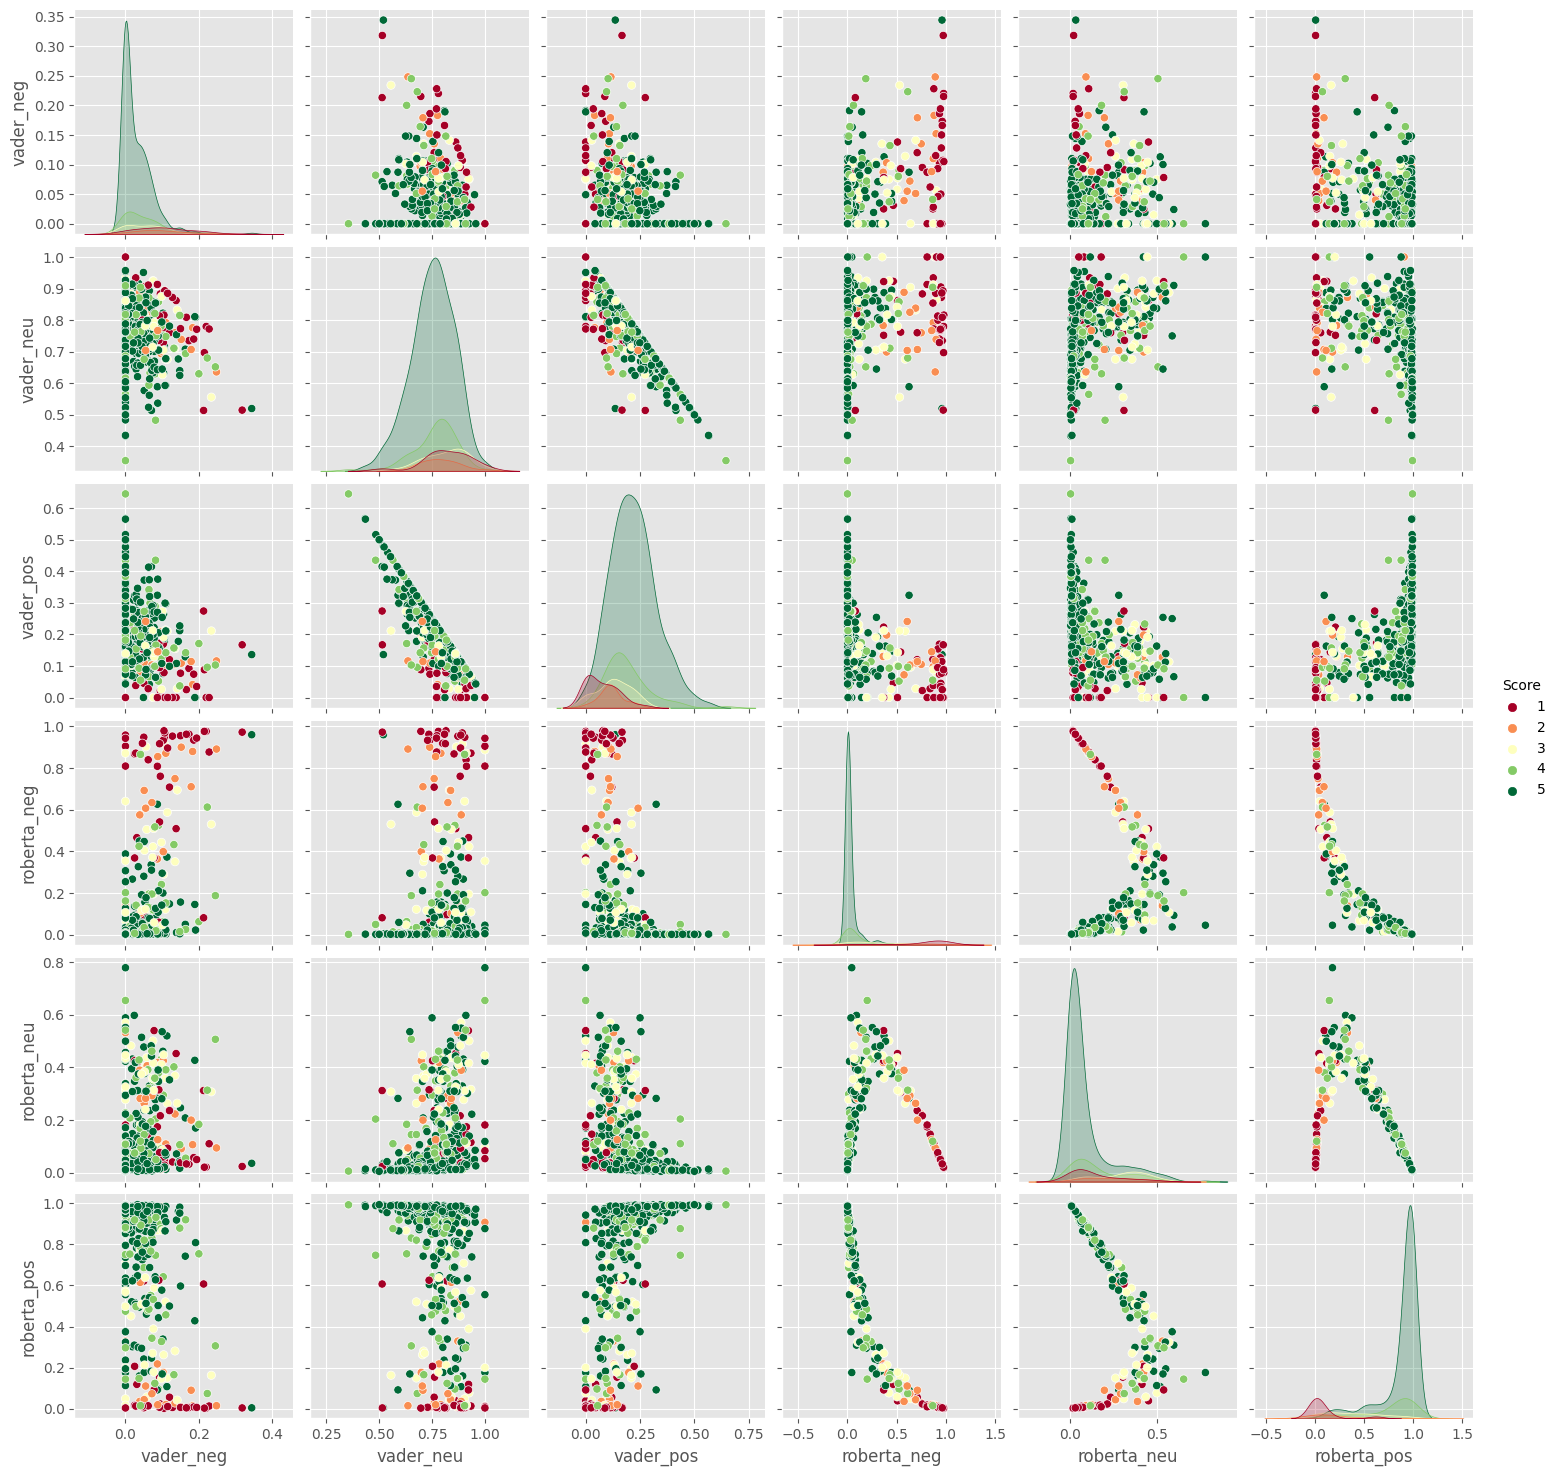

In [31]:
# VADER ve RoBERTa duygu skorlarının çiftli dağılım analizi

sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='Score',
            palette='RdYlGn')
plt.show()

In [32]:
# en olumlu RoBERTa skoruna sahip 1 puanlı yorumu bulma

results_df.query('Score == 1') \
    .sort_values('roberta_pos', ascending=False)['Text'].values[0]

'I felt energized within five minutes, but it lasted for about 45 minutes. I paid $3.99 for this drink. I could have just drunk a cup of coffee and saved my money.'

In [33]:
# en olumlu VADER skoruna sahip 1 puanlı yorumu bulma

results_df.query('Score == 1') \
    .sort_values('vader_pos', ascending=False)['Text'].values[0]

'So we cancelled the order.  It was cancelled without any problem.  That is a positive note...'

In [34]:
# # en olumlu Roberta skoruna sahip 5 puanlı yorumu bulma

results_df.query('Score == 5') \
    .sort_values('roberta_neg', ascending=False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

In [35]:
# # en olumsuz VADER skoruna sahip 5 puanlı yorumu bulma

results_df.query('Score == 5') \
    .sort_values('vader_neg', ascending=False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

In [39]:
# hugging face transformers ile hazır duygu analizi pipeline'ı Oluşturma

from transformers import pipeline
sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Device set to use cpu


In [40]:
sent_pipeline("I love music. Music is the best thing")

[{'label': 'POSITIVE', 'score': 0.999840259552002}]

In [41]:
sent_pipeline("Sorry but we can't be friends anymore.We should'nt talk!")

[{'label': 'NEGATIVE', 'score': 0.9984462857246399}]

sent_pipeline("yeeaahh")

# Ekstra Çalışmalar

In [1]:
# Import işlemleri

# Temel kütüphaneler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Metin işleme kütüphaneleri
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

# Görselleştirme için
from wordcloud import WordCloud, STOPWORDS

# NLP & Topic Modeling
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# İstatistiksel analiz
from collections import Counter
from scipy.stats import ttest_ind


In [2]:
df = pd.read_csv('../input/amazon-fine-food-reviews/Reviews.csv')

In [3]:
# unix timestamp sütununu tarih formatına dönüştürme

df['date'] = pd.to_datetime(df['Time'], unit='s')


In [4]:
# ürünlere göre yorum sayılarını hesaplama ve sıralama

product_counts = df.groupby('ProductId').size().rename('review_count')
product_counts = product_counts.sort_values(ascending=False)

In [5]:
# en çok yorum alan ilk 10 ürünü listeleme

N = 10
top_products = product_counts.head(N).reset_index().rename(columns={0: 'ProductId'})
top_products = top_products.rename(columns={'index':'ProductId'}) if 'index' in top_products.columns else top_products
print("Top", N, "ürün (ProductId, review_count):")
print(top_products)

Top 10 ürün (ProductId, review_count):
    ProductId  review_count
0  B007JFMH8M           913
1  B0026RQTGE           632
2  B002QWHJOU           632
3  B002QWP89S           632
4  B002QWP8H0           632
5  B003B3OOPA           623
6  B001EO5Q64           567
7  B0026KPDG8           564
8  B000VK8AVK           564
9  B006HYLW32           564


In [6]:
# ürün bazlı istatistiksel analiz ve yararlılık oranı hesaplama

prod_stats = df.groupby('ProductId').agg(
    review_count=('Id', 'count'),
    avg_score=('Score', 'mean'),
    help_num=('HelpfulnessNumerator', 'sum'),
    help_den=('HelpfulnessDenominator', 'sum')
).sort_values('review_count', ascending=False)

# Hesap: helpfulness oranı (denominator 0 ise NaN)
prod_stats['helpfulness_rate'] = np.where(prod_stats['help_den'] > 0,
                                         prod_stats['help_num'] / prod_stats['help_den'],
                                         np.nan)

top_products_stats = prod_stats.head(N).reset_index()
print(top_products_stats)


top_products_stats.to_csv('top_products_stats.csv', index=False)


    ProductId  review_count  avg_score  help_num  help_den  helpfulness_rate
0  B007JFMH8M           913   4.582694        41        46          0.891304
1  B0026RQTGE           632   4.588608       611       887          0.688839
2  B002QWHJOU           632   4.588608       611       887          0.688839
3  B002QWP89S           632   4.588608       611       887          0.688839
4  B002QWP8H0           632   4.588608       611       887          0.688839
5  B003B3OOPA           623   4.739968      2944      3415          0.862079
6  B001EO5Q64           567   4.746032      1947      2340          0.832051
7  B0026KPDG8           564   4.310284       488       705          0.692199
8  B000VK8AVK           564   4.310284       488       705          0.692199
9  B006HYLW32           564   4.310284       488       705          0.692199


In [7]:
# kullanıcı bazlı istatistiksel analiz ve yararlılık oranı hesaplama

user_stats_by_userid = df.groupby('UserId').agg(
    review_count=('Id', 'count'),
    avg_score=('Score', 'mean'),
    help_num=('HelpfulnessNumerator', 'sum'),
    help_den=('HelpfulnessDenominator', 'sum')
).sort_values('review_count', ascending=False)

user_stats_by_userid['helpfulness_rate'] = np.where(user_stats_by_userid['help_den'] > 0,
                                                   user_stats_by_userid['help_num'] / user_stats_by_userid['help_den'],
                                                   np.nan)

In [8]:
# en aktif ilk 10 kullanıcıyı listeleme

M = 10
top_users_userid = user_stats_by_userid.head(M).reset_index()
print("Top", M, "kullanıcı (UserId bazlı):")
print(top_users_userid)

Top 10 kullanıcı (UserId bazlı):
           UserId  review_count  avg_score  help_num  help_den  \
0  A3OXHLG6DIBRW8           448   4.535714      1344      1372   
1  A1YUL9PCJR3JTY           421   4.494062      1285      1380   
2   AY12DBB0U420B           389   4.647815       490       535   
3  A281NPSIMI1C2R           365   4.841096      1282      1458   
4  A1Z54EM24Y40LL           256   4.453125       385       432   
5  A1TMAVN4CEM8U8           204   4.833333       129       178   
6  A2MUGFV2TDQ47K           201   3.751244       251       310   
7  A3TVZM3ZIXG8YW           199   1.000000      2101      3084   
8  A3PJZ8TU8FDQ1K           178   4.601124       704       789   
9   AQQLWCMRNDFGI           176   3.954545       334       373   

   helpfulness_rate  
0          0.979592  
1          0.931159  
2          0.915888  
3          0.879287  
4          0.891204  
5          0.724719  
6          0.809677  
7          0.681258  
8          0.892269  
9          0.895442 

In [9]:
# profil isimlerine göre kullanıcı istatistikleri ve en aktif kullanıcılar

user_stats_by_name = df.groupby('ProfileName').agg(
    review_count=('Id', 'count'),
    avg_score=('Score', 'mean'),
    help_num=('HelpfulnessNumerator', 'sum'),
    help_den=('HelpfulnessDenominator', 'sum')
).sort_values('review_count', ascending=False)

user_stats_by_name['helpfulness_rate'] = np.where(user_stats_by_name['help_den'] > 0,
                                                  user_stats_by_name['help_num'] / user_stats_by_name['help_den'],
                                                  np.nan)

top_users_name = user_stats_by_name.head(M).reset_index()
print("Top", M, "kullanıcı (Profil Name bazlı):")
print(top_users_name)


Top 10 kullanıcı (Profil Name bazlı):
                              ProfileName  review_count  avg_score  help_num  \
0                        C. F. Hill "CFH"           451   4.532151      1344   
1         O. Brown "Ms. O. Khannah-Brown"           421   4.494062      1285   
2                           Gary Peterson           389   4.647815       490   
3  Rebecca of Amazon "The Rebecca Review"           365   4.841096      1282   
4                                   Chris           363   4.179063       613   
5                                   Linda           290   4.017241       274   
6                                    John           261   4.222222       501   
7                                    Mike           260   3.907692       227   
8                                      c2           256   4.453125       385   
9                                   Laura           253   4.185771       348   

   help_den  helpfulness_rate  
0      1372          0.979592  
1      1380      

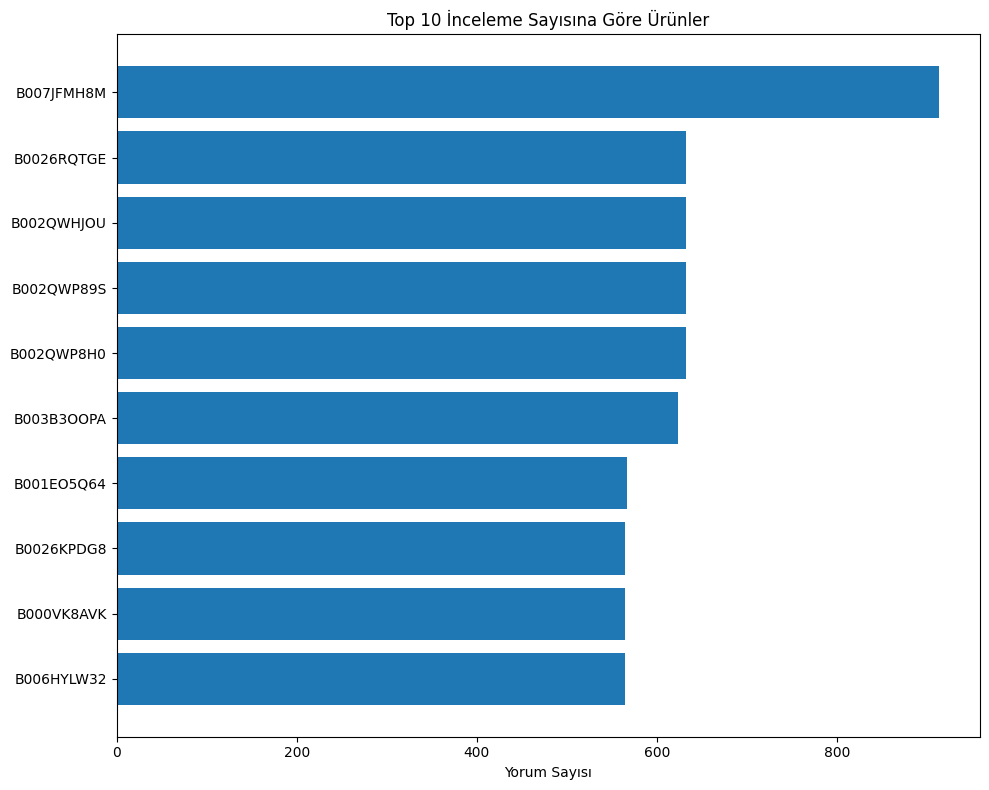

In [10]:
# İnceleme Sayısına Göre Ürünler Görselleştirmesi

plt.figure(figsize=(10, 8))
top = prod_stats.head(N)
plt.barh(top.index[::-1], top['review_count'][::-1])   # ters çevirme: en çok solda üstte
plt.xlabel('Yorum Sayısı')
plt.title(f'Top {N} İnceleme Sayısına Göre Ürünler')
plt.tight_layout()
plt.show()

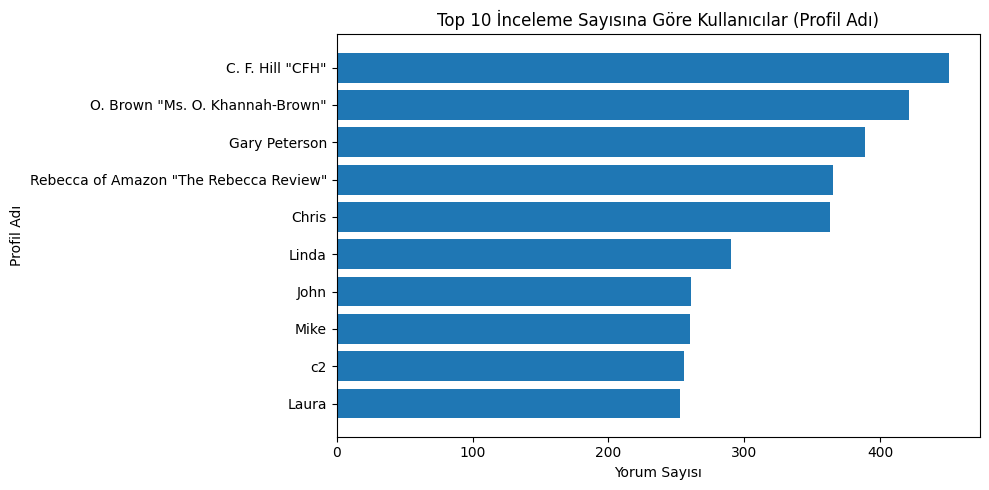

In [11]:
# profile name bazında top 10 kullanıcı görselleştirmesi
M = 10
top_u_name = user_stats_by_name.head(M).reset_index()

plt.figure(figsize=(10, 5))
plt.barh(top_u_name['ProfileName'][::-1], top_u_name['review_count'][::-1])
plt.xlabel('Yorum Sayısı')
plt.ylabel('Profil Adı')
plt.title(f'Top {M} İnceleme Sayısına Göre Kullanıcılar (Profil Adı)')
plt.tight_layout()
plt.show()


In [12]:
# ürün yorum dağılımını analiz etme ve kümülatif yüzde hesaplama

prod_counts_df = product_counts.reset_index().rename(columns={0: 'ProductId', 'ProductId': 'ProductId', 'index':'ProductId'}).rename(columns={0:'review_count'})
prod_counts_df.columns = ['ProductId', 'review_count']
prod_counts_df = prod_counts_df.sort_values('review_count', ascending=False).reset_index(drop=True)
prod_counts_df['cum_reviews'] = prod_counts_df['review_count'].cumsum()
prod_counts_df['cum_pct'] = 100 * prod_counts_df['cum_reviews'] / prod_counts_df['review_count'].sum()


print("Top 10 ürün toplam yorum içindeki payı (yüzde):", prod_counts_df.loc[:9,'cum_pct'].iloc[-1])

Top 10 ürün toplam yorum içindeki payı (yüzde): 1.1123151565474074


In [13]:
# yararlılık oranı ve yorum uzunluğu özellikleri ekleme

df['helpfulness_ratio'] = np.where(df['HelpfulnessDenominator'] > 0,
                                   df['HelpfulnessNumerator'] / df['HelpfulnessDenominator'],
                                   np.nan)

# Yorum uzunluğu (kelime sayısı)
df['word_count'] = df['Text'].apply(lambda x: len(str(x).split()))

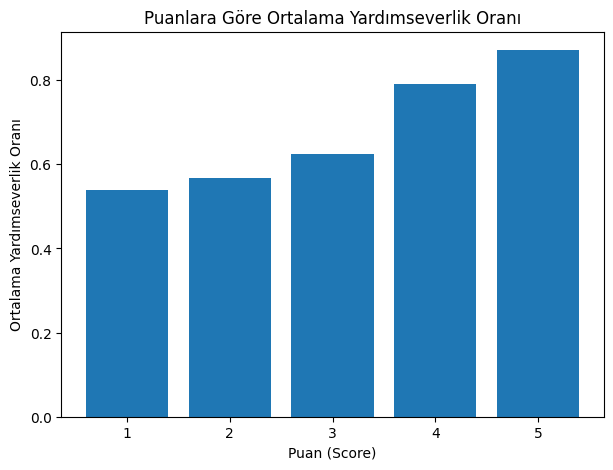

In [14]:
# puanlara göre ortalama yardımseverlik oranı görselleştirmesi

score_helpfulness = df.groupby('Score')['helpfulness_ratio'].mean().reset_index()

plt.figure(figsize=(7,5))
plt.bar(score_helpfulness['Score'], score_helpfulness['helpfulness_ratio'])
plt.xlabel('Puan (Score)')
plt.ylabel('Ortalama Yardımseverlik Oranı')
plt.title('Puanlara Göre Ortalama Yardımseverlik Oranı')
plt.show()

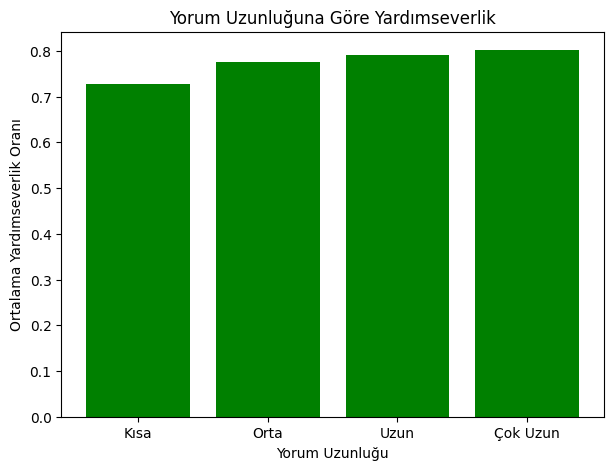

In [18]:
# yorum uzunluğuna göre yardımseverlik görselleştirmesi

df['length_category'] = pd.qcut(df['word_count'], q=4, labels=['Kısa', 'Orta', 'Uzun', 'Çok Uzun'])

length_helpfulness = df.groupby('length_category')['helpfulness_ratio'].mean().reset_index()

plt.figure(figsize=(7,5))
plt.bar(length_helpfulness['length_category'], length_helpfulness['helpfulness_ratio'], color='green')
plt.xlabel('Yorum Uzunluğu')
plt.ylabel('Ortalama Yardımseverlik Oranı')
plt.title('Yorum Uzunluğuna Göre Yardımseverlik')
plt.show()

In [19]:
# metin temizleme ve ön işleme fonksiyonu

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)  # noktalama vs.
    words = [lemmatizer.lemmatize(w) for w in text.split() if w not in stop_words]
    return ' '.join(words)

df['clean_text'] = df['Text'].apply(clean_text)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [99]:
## Topic Modelleme

custom_stopwords = list(text.ENGLISH_STOP_WORDS) + ['br']
vectorizer = CountVectorizer(max_df = 0.9, min_df = 50, stop_words = "english")
X = vectorizer.fit_transform(df['clean_text'])

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)

terms = vectorizer.get_feature_names_out()

for i, topic in enumerate(lda.components_):
    top_terms = [terms[j] for j in topic.argsort()[:-11:-1]]
    print(f"🧩 Topic {i+1}: {', '.join(top_terms)}")

🧩 Topic 1: tea, br, taste, like, flavor, drink, sugar, water, good, product
🧩 Topic 2: coffee, br, like, cup, product, good, taste, flavor, box, great
🧩 Topic 3: great, good, love, chocolate, like, taste, flavor, store, amazon, price
🧩 Topic 4: food, dog, cat, treat, love, br, like, product, day, eat
🧩 Topic 5: br, like, taste, good, make, product, great, use, food, flavor


In [21]:
# anahtar kelimelere göre yorum puanlarını analiz etme

keywords = ['taste', 'delivery', 'packaging', 'fresh', 'expired']

for word in keywords:
    mask = df['clean_text'].str.contains(word, case=False, na=False)
    avg_score = df.loc[mask, 'Score'].mean()
    print(f"'{word}' geçen yorumların ortalama puanı: {avg_score:.2f}")


'taste' geçen yorumların ortalama puanı: 4.01
'delivery' geçen yorumların ortalama puanı: 4.46
'packaging' geçen yorumların ortalama puanı: 3.77
'fresh' geçen yorumların ortalama puanı: 4.42
'expired' geçen yorumların ortalama puanı: 2.59


✅ En sık 5 yıldız kelimeleri:
        word   count
0        br  147227
1      like  143171
2      love  127533
3     great  125527
4      good  115647
5     taste  113632
6       one  112664
7    flavor  104338
8       tea   97158
9   product   96301
10   coffee   94849
11     food   93517
12      get   71888
13     make   69521
14      dog   65532
❌ En sık 1 yıldız kelimeleri:
        word  count
0        br  27878
1   product  26208
2      like  25782
3     taste  22178
4       one  19099
5      food  18217
6     would  16657
7    coffee  12591
8    flavor  12018
9       dog  11979
10     good  11708
11     even  11347
12     dont  10799
13      get  10334
14      buy  10211


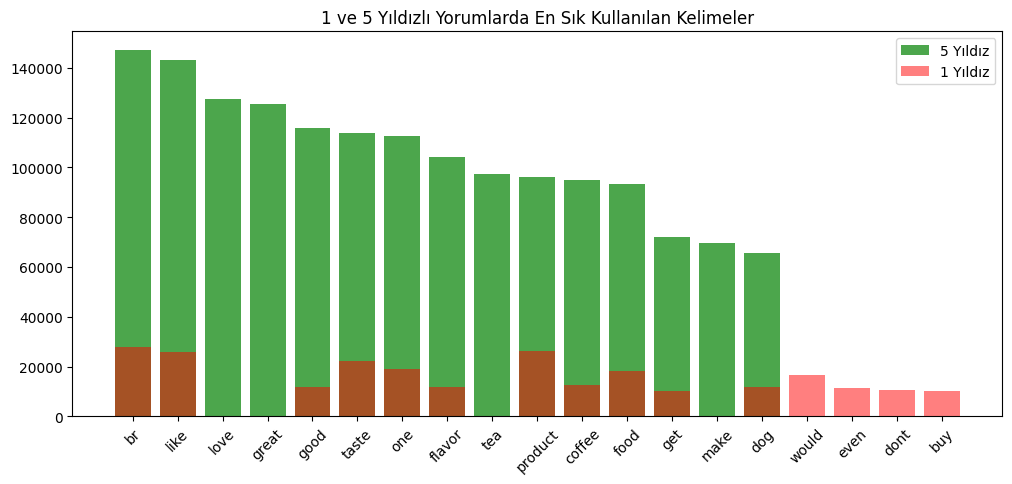

In [22]:
# puanlara göre en sık kullanılan kelimeleri analiz etme ve görselleştirme

def get_top_words(df_subset, n=15):
    words = ' '.join(df_subset['clean_text']).split()
    common = Counter(words).most_common(n)
    return pd.DataFrame(common, columns=['word', 'count'])

top_5 = get_top_words(df[df['Score'] == 5])
top_1 = get_top_words(df[df['Score'] == 1])

print("✅ En sık 5 yıldız kelimeleri:\n", top_5)
print("❌ En sık 1 yıldız kelimeleri:\n", top_1)

# Görselleştirme
plt.figure(figsize=(12,5))
plt.bar(top_5['word'], top_5['count'], color='green', alpha=0.7, label='5 Yıldız')
plt.bar(top_1['word'], top_1['count'], color='red', alpha=0.5, label='1 Yıldız')
plt.legend()
plt.xticks(rotation=45)
plt.title('1 ve 5 Yıldızlı Yorumlarda En Sık Kullanılan Kelimeler')
plt.show()


🏆 En iyi ürünler:
         ProductId  review_count  avg_score
8253   B000ED9L9E           113   4.973451
17287  B000O5DI1E           107   4.906542
16945  B000NMJWZO           542   4.881919
49159  B003QDRJXY           264   4.837121
47846  B003KRHDMI           132   4.833333
71762  B007R900WA           170   4.823529
28118  B001E8DHPW           389   4.802057
11212  B000GAT6NG           389   4.802057
56627  B004EAGP74           389   4.802057
8952   B000ET4SM8           176   4.801136
⚠️ Tartışmalı ürünler:
         ProductId  review_count  avg_score
69165  B006N3I69A           131   1.343511
21233  B000X1Q1G8           184   1.695652


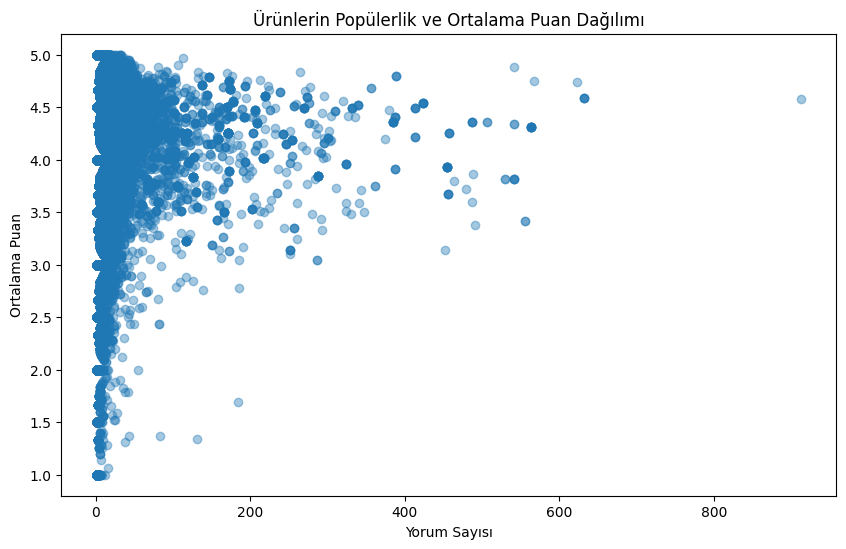

In [23]:
# ürün performans analizi: en iyi ve tartışmalı ürünleri belirleme

product_summary = df.groupby('ProductId').agg(
    review_count=('Id', 'count'),
    avg_score=('Score', 'mean')
).reset_index()

# Kazananlar
winners = product_summary.query('review_count >= 100 and avg_score >= 4.5')
# Tartışmalı ürünler
controversial = product_summary.query('review_count >= 100 and avg_score <= 2.5')

print("🏆 En iyi ürünler:\n", winners.sort_values('avg_score', ascending=False).head(10))
print("⚠️ Tartışmalı ürünler:\n", controversial.sort_values('avg_score').head(10))

plt.figure(figsize=(10,6))
plt.scatter(product_summary['review_count'], product_summary['avg_score'], alpha=0.4)
plt.xlabel('Yorum Sayısı')
plt.ylabel('Ortalama Puan')
plt.title('Ürünlerin Popülerlik ve Ortalama Puan Dağılımı')
plt.show()


In [24]:
# tarih sütunu kontrolü ve oluşturma

if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df['Time'], unit='s')

In [25]:
# kullanıcı sadakat metrikleri hesaplama

user_review_counts = df.groupby('UserId').size().rename('review_count')
distinct_products = df.groupby('UserId')['ProductId'].nunique().rename('distinct_products')
max_per_product = (df.groupby(['UserId','ProductId']).size()
                    .groupby('UserId').max().rename('max_per_product'))

user_loyalty = pd.concat([user_review_counts, distinct_products, max_per_product], axis=1).fillna(0).reset_index()
user_loyalty['share_top_product'] = user_loyalty['max_per_product'] / user_loyalty['review_count']

In [26]:
# kullanıcı profil isimlerini eşleştirme ve sadakat analizini tamamlama

user_names = (df.groupby('UserId')['ProfileName']
                .agg(lambda x: x.dropna().mode().iloc[0] if not x.dropna().mode().empty else x.dropna().iloc[0] if len(x.dropna())>0 else "")
                .to_dict())

user_loyalty['ProfileName'] = user_loyalty['UserId'].map(user_names)
user_loyalty.sort_values('review_count', ascending=False).head(20).to_csv('user_loyalty_top20.csv', index=False)
print("Top 20 kullanıcı (review_count, distinct_products, share_top_product):")
print(user_loyalty.sort_values('review_count', ascending=False).head(20))

Top 20 kullanıcı (review_count, distinct_products, share_top_product):
                UserId  review_count  distinct_products  max_per_product  \
182011  A3OXHLG6DIBRW8           448                420                2   
65586   A1YUL9PCJR3JTY           421                309                4   
252275   AY12DBB0U420B           389                382                2   
82919   A281NPSIMI1C2R           365                321                5   
66162   A1Z54EM24Y40LL           256                251                2   
55736   A1TMAVN4CEM8U8           204                 90                6   
110863  A2MUGFV2TDQ47K           201                201                1   
191283  A3TVZM3ZIXG8YW           199                 38               10   
183161  A3PJZ8TU8FDQ1K           178                118                5   
238453   AQQLWCMRNDFGI           176                167                2   
122371  A2SZLNSI5KOQJT           175                131                5   
85706   A29JUMRL1

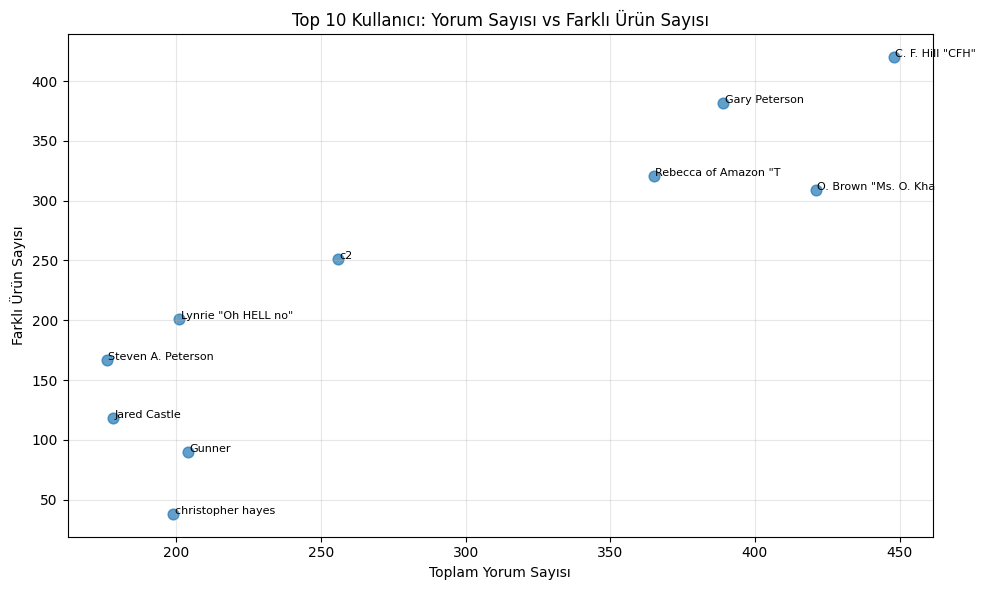

In [28]:
#  kullanıcı: yorum sayısı vs farklı ürün sayısı görselleştirmesi

top_k = 10
top_users = user_loyalty.sort_values('review_count', ascending=False).head(top_k).copy()

plt.figure(figsize=(10,6))
plt.scatter(top_users['review_count'], top_users['distinct_products'], s=60, alpha=0.7)
for i, row in top_users.iterrows():
    label = f"{row['ProfileName'][:20] if pd.notna(row['ProfileName']) else row['UserId'][:12]}"
    plt.text(row['review_count']+0.5, row['distinct_products'], label, fontsize=8)
plt.xlabel('Toplam Yorum Sayısı')
plt.ylabel('Farklı Ürün Sayısı')
plt.title(f'Top {top_k} Kullanıcı: Yorum Sayısı vs Farklı Ürün Sayısı')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

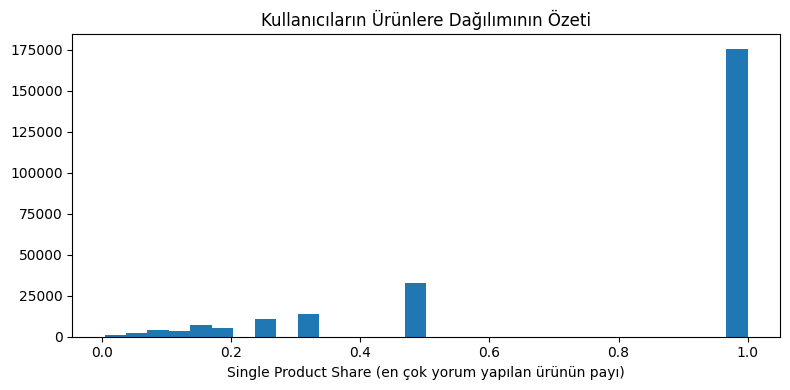

In [29]:
# kullanıcıların ürünlere dağılımının özeti görselleştirmesi

plt.figure(figsize=(8,4))
plt.hist(user_loyalty['share_top_product'].dropna(), bins=30)
plt.xlabel('Single Product Share (en çok yorum yapılan ürünün payı)')
plt.title('Kullanıcıların Ürünlere Dağılımının Özeti')
plt.tight_layout()
plt.show()

In [30]:
# sadık kullanıcıları belirleme ve lineer regresyon için hazırlık

# Parametreler
min_reviews = 20        
top_n_users = 12        

# Hangi kullanıcılar (en çok yorumu olan ve min_reviews >=)
candidate_users = user_loyalty[user_loyalty['review_count'] >= min_reviews].sort_values('review_count', ascending=False)
print(f"Sadık (>= {min_reviews} yorum) kullanıcı sayısı: {len(candidate_users)}")

Sadık (>= 20 yorum) kullanıcı sayısı: 1891


In [31]:
# kullanıcı puan tutarlılık analizi ve zaman içinde trend hesaplama

consistency_rows = []
for uid in candidate_users['UserId'].head(200):  # performans için ilk 200'e alıyoruz (gerektiğinde azalt)
    sub = df[df['UserId']==uid].set_index('date').sort_index()
    monthly = sub['Score'].resample('M').mean().dropna()
    if len(monthly) < 6:
        continue
    x = np.arange(len(monthly)).reshape(-1,1)  # zaman indeksini 0..n-1 yapıyoruz
    y = monthly.values
    model = LinearRegression().fit(x,y)
    slope = float(model.coef_[0])   # birim: puan / ay-indeks
    std_score = float(y.std())
    avg_score = float(y.mean())
    consistency_rows.append({'UserId': uid, 'ProfileName': user_names.get(uid, ''), 'n_months': len(monthly),
                              'avg_score_monthly': avg_score, 'std_score_monthly': std_score, 'slope_per_month': slope,
                              'total_reviews': int(candidate_users.loc[candidate_users['UserId']==uid,'review_count'].iloc[0])})

consistency_df = pd.DataFrame(consistency_rows).sort_values('total_reviews', ascending=False)
consistency_df.to_csv('user_score_consistency.csv', index=False)
print("Sadık kullanıcıların puan tutarlılığı (ilk 20):")
print(consistency_df.head(20))


Sadık kullanıcıların puan tutarlılığı (ilk 20):
            UserId                                 ProfileName  n_months  \
0   A3OXHLG6DIBRW8                            C. F. Hill "CFH"        45   
1   A1YUL9PCJR3JTY             O. Brown "Ms. O. Khannah-Brown"        32   
2    AY12DBB0U420B                               Gary Peterson        35   
3   A281NPSIMI1C2R      Rebecca of Amazon "The Rebecca Review"        61   
4   A1Z54EM24Y40LL                                          c2        41   
5   A1TMAVN4CEM8U8                                      Gunner        15   
6   A2MUGFV2TDQ47K                         Lynrie "Oh HELL no"        35   
7   A3PJZ8TU8FDQ1K                                Jared Castle        33   
8    AQQLWCMRNDFGI                          Steven A. Peterson        41   
9   A2SZLNSI5KOQJT  Carrie, "Formerly &#34;Sister Carrie&#34;"        29   
10   AZV26LP92E6WU                   M. Hammond "ColemanFlGuy"        32   
12   AY1EF0GOH80EK                      

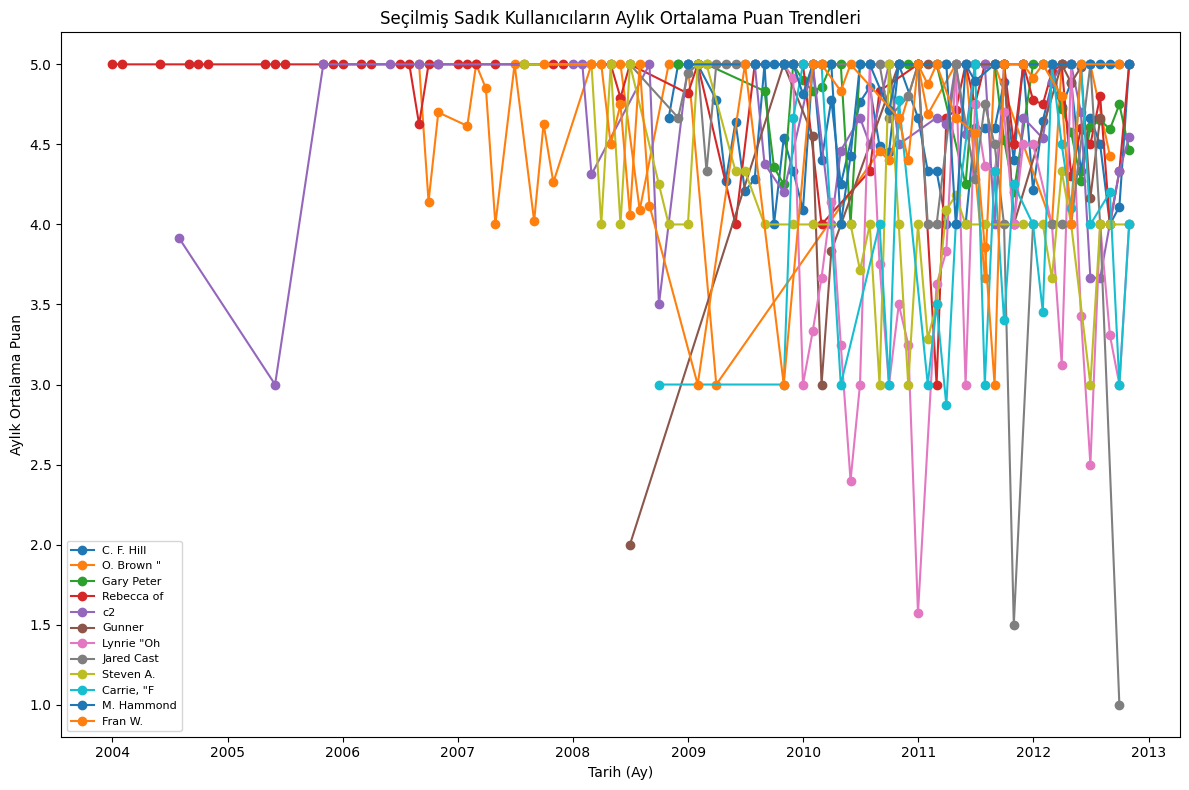

In [33]:
# seçilmiş sadık kullanıcıların aylık ortalama puan trendleri

plot_users = consistency_df.sort_values('total_reviews', ascending=False).head(top_n_users)['UserId'].tolist()
plt.figure(figsize=(12, 8))
for uid in plot_users:
    sub = df[df['UserId']==uid].set_index('date').sort_index()
    monthly = sub['Score'].resample('M').mean().dropna()
    if len(monthly) < 3: 
        continue
    plt.plot(monthly.index, monthly.values, marker='o', label=user_names.get(uid, uid)[:10])
plt.legend(loc='best', fontsize=8)
plt.xlabel('Tarih (Ay)')
plt.ylabel('Aylık Ortalama Puan')
plt.title('Seçilmiş Sadık Kullanıcıların Aylık Ortalama Puan Trendleri')
plt.tight_layout()
plt.show()


In [34]:
# kullanıcı puan trendlerinin özet istatistikleri

neg = (consistency_df['slope_per_month'] < 0).sum()
pos = (consistency_df['slope_per_month'] > 0).sum()
print(f"Analize giren sadık kullanıcılar: {len(consistency_df)} | Negatif slope: {neg} | Pozitif slope: {pos}")

Analize giren sadık kullanıcılar: 185 | Negatif slope: 119 | Pozitif slope: 66


In [38]:
# kullanıcı profil isimlerini sınıflandırma fonksiyonu

from scipy.stats import ttest_ind

def classify_profilename(name, userid=None):
   
    if pd.isna(name) or str(name).strip()=='':
        return 'missing'
        
    s = str(name).strip()
    if s.lower() in ['anonymous','anon','n/a','none','user','unknown']:
        return 'anonymous'
        
    if userid is not None and str(s).lower() == str(userid).lower():
        return 'userid_same'
   
    if ' ' in s and len(s) > 3:
        return 'real_name_like'
   
    if any(ch.isdigit() for ch in s) and ' ' not in s:
        return 'handle_like'
    
    if re.search(r'[\'\"]', s) or re.search(r'\.', s):
        return 'other'
    
    return 'real_name_like'

In [39]:
# profil isimlerini sınıflandırma ve isimlendirme metrikleri oluşturma

df['profilename_class'] = df.apply(lambda r: classify_profilename(r['ProfileName'], r['UserId']), axis=1)
df['profilename_named_strict'] = df['profilename_class'].apply(lambda x: 'named' if x=='real_name_like' else 'anonymous')
df['profilename_named_loose'] = df['profilename_class'].apply(lambda x: 'named' if x in ['real_name_like','other'] else 'anonymous')

In [40]:
# strict isimlendirme kriterine göre puan istatistikleri

grp_strict = df.groupby('profilename_named_strict')['Score'].agg(['count','mean','std']).reset_index()
print("ProfileName Strict Gruplama (count, mean, std):")
print(grp_strict)

ProfileName Strict Gruplama (count, mean, std):
  profilename_named_strict   count      mean       std
0                anonymous   25781  4.175284  1.343098
1                    named  542673  4.183575  1.308864


In [41]:
# isimli ve anonim kullanıcıların puanları arasındaki istatistiksel fark testi

scores_named = df[df['profilename_named_strict']=='named']['Score'].dropna()
scores_anon = df[df['profilename_named_strict']=='anonymous']['Score'].dropna()
tstat, pval = ttest_ind(scores_named, scores_anon, equal_var=False)
print(f"Strict t-test: t={tstat:.3f}, p={pval:.3e}")

Strict t-test: t=0.969, p=3.323e-01


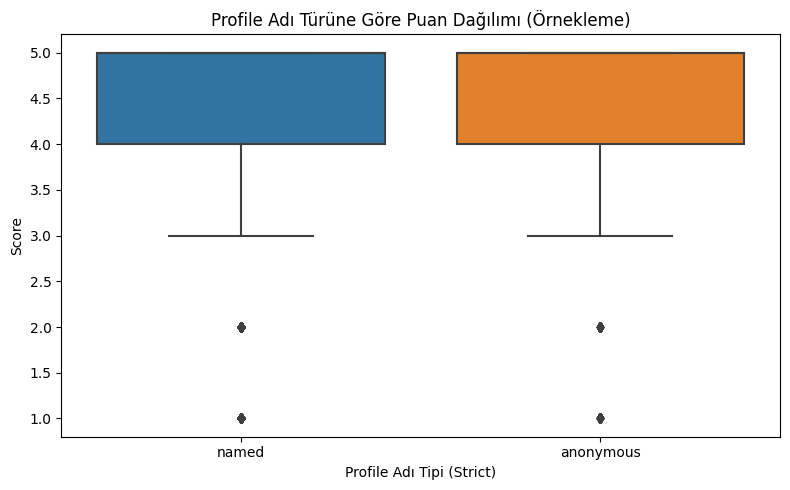

In [43]:
# profile Adı türüne göre puan dağılımı

plt.figure(figsize=(8,5))
import seaborn as sns
sns.boxplot(x='profilename_named_strict', y='Score', data=df.sample(min(len(df), 20000), random_state=42))  # örnekleme ile hızlandır
plt.xlabel('Profile Adı Tipi (Strict)')
plt.ylabel('Score')
plt.title('Profile Adı Türüne Göre Puan Dağılımı (Örnekleme)')
plt.tight_layout()
plt.show()

In [44]:
# loose isimlendirme kriterine göre puan istatistikleri ve T-Test

grp_loose = df.groupby('profilename_named_loose')['Score'].agg(['count','mean','std']).reset_index()
print("ProfileName Loose Gruplama (count, mean, std):")
print(grp_loose)
scores_named_l = df[df['profilename_named_loose']=='named']['Score'].dropna()
scores_anon_l = df[df['profilename_named_loose']=='anonymous']['Score'].dropna()
tstat_l, pval_l = ttest_ind(scores_named_l, scores_anon_l, equal_var=False)
print(f"Loose t-test: t={tstat_l:.3f}, p={pval_l:.3e}")

ProfileName Loose Gruplama (count, mean, std):
  profilename_named_loose   count      mean       std
0               anonymous   22906  4.173230  1.345534
1                   named  545548  4.183617  1.308941
Loose t-test: t=1.146, p=2.519e-01


In [45]:
# yorum uzunluklarını hesaplama ve istatistiksel özet

df['word_count'] = df['Text'].apply(lambda x: len(str(x).split()))

# Ortalama, medyan, min, max kontrolü
print(df['word_count'].describe())

count    568454.000000
mean         80.264023
std          79.455384
min           3.000000
25%          33.000000
50%          56.000000
75%          98.000000
max        3432.000000
Name: word_count, dtype: float64


In [47]:
# Yorum Uzunluğuna Göre Kategorize Etme ve Puan Ortalamalarını Karşılaştırma

threshold = 500

# Yeni sütun: yorum tipi
df['comment_length_type'] = df['word_count'].apply(lambda x: 'Uzun' if x > threshold else 'Kısa')

# Her kategorideki ortalama puanı hesapla
avg_scores = df.groupby('comment_length_type')['Score'].mean().reset_index()
print(avg_scores)

  comment_length_type     Score
0                Kısa  4.184795
1                Uzun  3.836531


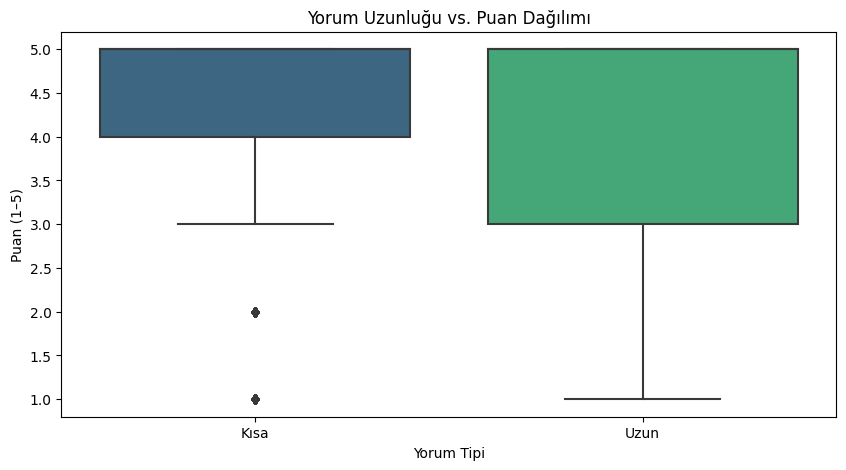

In [48]:
# Yorum Uzunluğu vs. Puan Dağılımı Görselleştirmesi

plt.figure(figsize=(10, 5))
sns.boxplot(x='comment_length_type', y='Score', data=df, palette='viridis')
plt.title('Yorum Uzunluğu vs. Puan Dağılımı')
plt.xlabel('Yorum Tipi')
plt.ylabel('Puan (1–5)')
plt.show()


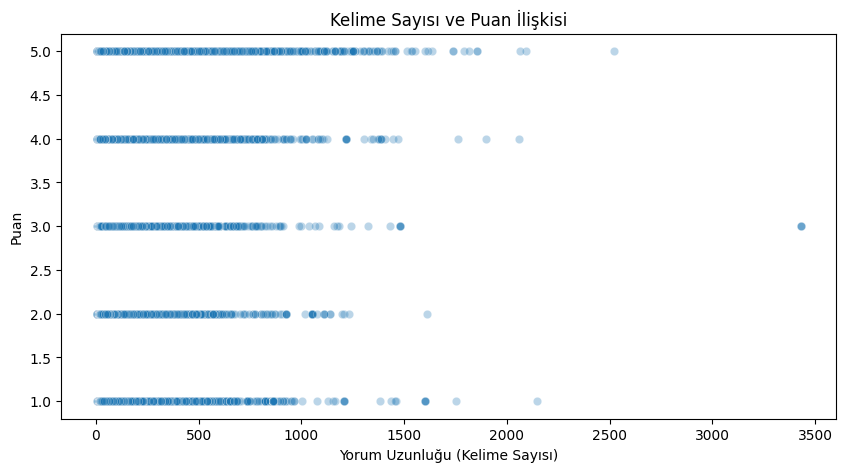

In [49]:
# Kelime Sayısı ve Puan İlişkisi

plt.figure(figsize=(10, 5))
sns.scatterplot(x='word_count', y='Score', data=df, alpha=0.3)
plt.title('Kelime Sayısı ve Puan İlişkisi')
plt.xlabel('Yorum Uzunluğu (Kelime Sayısı)')
plt.ylabel('Puan')
plt.show()


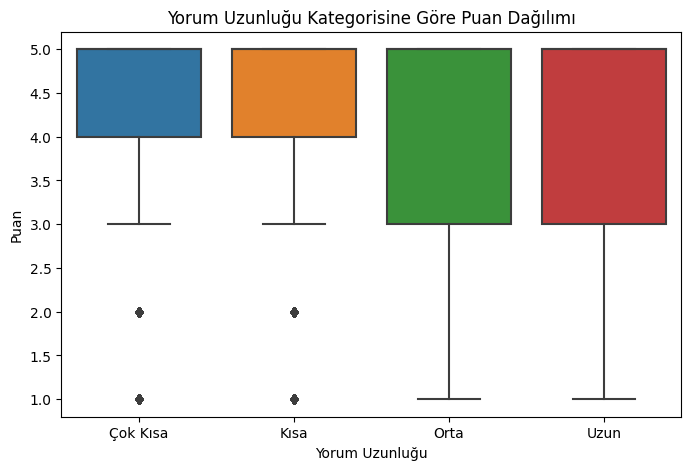

In [50]:
# Yorum Uzunluğu Kategorisine Göre Puan Dağılımı

def classify_length(x):
    if x < 50:
        return 'Çok Kısa'
    elif x < 150:
        return 'Kısa'
    elif x < 300:
        return 'Orta'
    else:
        return 'Uzun'

df['length_category'] = df['word_count'].apply(classify_length)

plt.figure(figsize=(8, 5))
sns.boxplot(x='length_category', y='Score', data=df, order=['Çok Kısa', 'Kısa', 'Orta', 'Uzun'])
plt.title('Yorum Uzunluğu Kategorisine Göre Puan Dağılımı')
plt.xlabel('Yorum Uzunluğu')
plt.ylabel('Puan')
plt.show()


In [51]:
avg_scores = df.groupby('comment_length_type')['Score'].mean().reset_index()
print(avg_scores)


  comment_length_type     Score
0                Kısa  4.184795
1                Uzun  3.836531


In [52]:
df.groupby('comment_length_type')['Score'].mean()


comment_length_type
Kısa    4.184795
Uzun    3.836531
Name: Score, dtype: float64

In [53]:
df.groupby('length_category')['Score'].mean()


length_category
Kısa        4.101991
Orta        4.004454
Uzun        3.956789
Çok Kısa    4.316177
Name: Score, dtype: float64

In [54]:
# Gerekli kütüphaneler
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [55]:
# Summary sentiment
df['summary_sentiment'] = df['Summary'].astype(str).apply(lambda x: sid.polarity_scores(x)['compound'])

# Text sentiment
df['text_sentiment'] = df['Text'].astype(str).apply(lambda x: sid.polarity_scores(x)['compound'])

# Örnek kontrol
df[['Summary', 'summary_sentiment', 'Text', 'text_sentiment']].head()


,Summary,summary_sentiment,Text,text_sentiment
0,Good Quality Dog Food,0.4404,I have bought several of the Vitality canned d...,0.9441
1,Not as Advertised,0.0000,Product arrived labeled as Jumbo Salted Peanut...,-0.5664
2,"""Delight"" says it all",0.0000,This is a confection that has been around a fe...,0.8265
3,Cough Medicine,0.0000,If you are looking for the secret ingredient i...,0.0000
4,Great taffy,0.6249,Great taffy at a great price. There was a wid...,0.9468


In [56]:
# Fark sütunu
df['sentiment_diff'] = df['summary_sentiment'] - df['text_sentiment']

# Örnek: Farkı en büyük olan 5 yorum
df.sort_values('sentiment_diff', ascending=False)[['Summary', 'Text', 'summary_sentiment', 'text_sentiment', 'sentiment_diff']].head()


,Summary,Text,summary_sentiment,text_sentiment,sentiment_diff
470258,Very good Raw natural almonds at a GREAT price!,Almonds are very healthful! (Eat a handful eve...,0.9018,-0.9877,1.8895
460407,"Like Water, But Better! Love At First Sip!","First of all, I'm the type of person who wants...",0.9183,-0.9631,1.8814
431877,Love Love Love this diaper ointment,I bought this ointment at a friends recommenda...,0.9274,-0.9416,1.8690
126438,Do Not Purchase. HORRIBLE HORRIBLE HORRIBLE,I've been using various truffle oils for the l...,0.8800,-0.9755,1.8555
79389,LOVE LOVE LOVE the Almond Cashew with Flax,HATE HATE HATE the gooey mess I was just sent ...,0.9501,-0.8957,1.8458


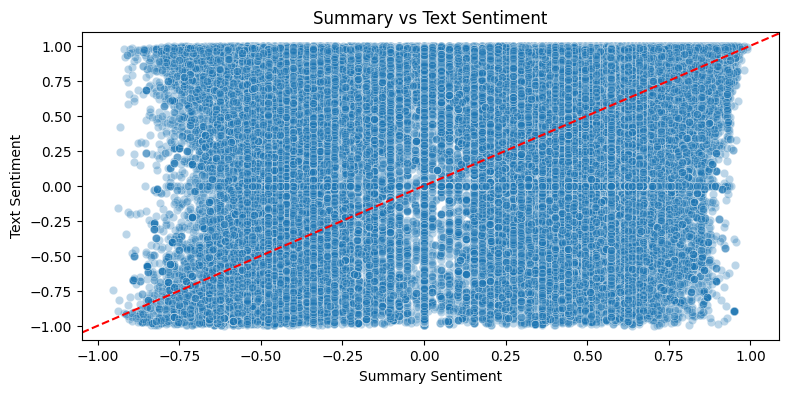

In [61]:
# Summary vs Text Sentiment Görselleştirmesi

plt.figure(figsize=(9, 4))
sns.scatterplot(x='summary_sentiment', y='text_sentiment', data=df, alpha=0.3)
plt.axline((0, 0), slope=1, color='red', linestyle='--')  # y=x çizgisi
plt.xlabel('Summary Sentiment')
plt.ylabel('Text Sentiment')
plt.title('Summary vs Text Sentiment')
plt.show()


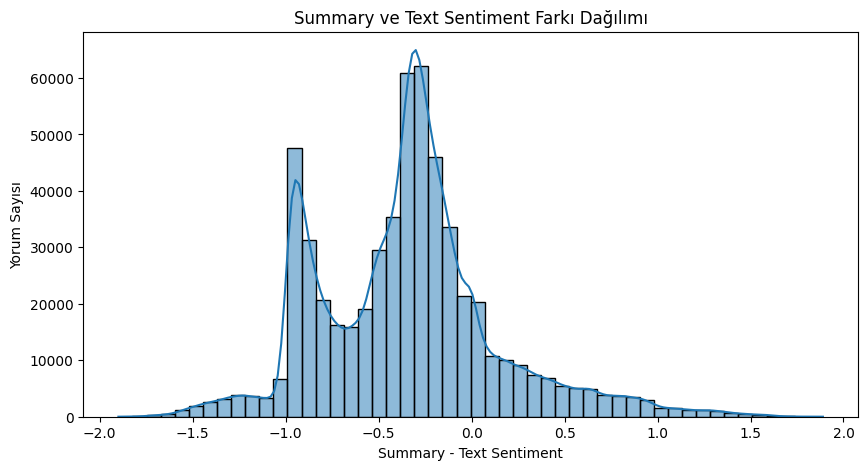

In [63]:
# Summary ve Text Sentiment Farkı Dağılımı Görselleştirmesi

plt.figure(figsize=(10,5))
sns.histplot(df['sentiment_diff'], bins=50, kde=True)
plt.title('Summary ve Text Sentiment Farkı Dağılımı')
plt.xlabel('Summary - Text Sentiment')
plt.ylabel('Yorum Sayısı')
plt.show()


In [64]:
# Özet pozitif (>0.3) ve metin negatif (<-0.3) yorumlar
summary_pos_text_neg = df[(df['summary_sentiment'] > 0.3) & (df['text_sentiment'] < -0.3)]

# En üst 5 örnek
summary_pos_text_neg[['Summary', 'Text', 'Score', 'summary_sentiment', 'text_sentiment']].head()


,Summary,Text,Score,summary_sentiment,text_sentiment
11,"My cats LOVE this ""diet"" food better than thei...",One of my boys needed to lose some weight and ...,5,0.8331,-0.7579
53,not ass kickin,we're used to spicy foods down here in south t...,3,0.4310,-0.3612
121,Perfect Cat Food For Older Cats!,This cat food was recommended by my vet becaus...,5,0.6114,-0.3626
138,Simply the BEST!,I keep trying other brands.... cheaper brands....,5,0.7371,-0.4199
156,Great Deal,What a deal this is the healthiest salt you ca...,5,0.6249,-0.7269


In [65]:
# Özet negatif (<-0.3) ve metin pozitif (>0.3) yorumlar
summary_neg_text_pos = df[(df['summary_sentiment'] < -0.3) & (df['text_sentiment'] > 0.3)]

# En üst 5 örnek
summary_neg_text_pos[['Summary', 'Text', 'Score', 'summary_sentiment', 'text_sentiment']].head()


,Summary,Text,Score,summary_sentiment,text_sentiment
16,poor taste,I love eating them and they are good for watch...,2,-0.4767,0.7481
57,How can you go wrong!,"It is chocolate, what can I say. Great variet...",5,-0.5255,0.9100
73,Warning! WARNING! -ALCOHOL SUGARS!,Buyer Beware Please! This sweetener is not for...,1,-0.7513,0.9665
106,disappointing,not what I was expecting in terms of the compa...,3,-0.4939,0.5719
107,Wasting Vinegar on a Cucumber is a Shame!,I first bought pickled asparagus at an Amish m...,5,-0.7263,0.9503


In [66]:
# Tutarsızlık skoru = özet ve metin arasındaki farkın mutlak değeri
df['inconsistency_score'] = abs(df['sentiment_diff'])

# Tutarsız yorumları en yüksekten sıralamak
df.sort_values('inconsistency_score', ascending=False)[['Summary', 'Text', 'Score', 'inconsistency_score']].head(10)


,Summary,Text,Score,inconsistency_score
441875,AWFUL- AWFUL- NASTY- HORRIBLE,Do your research on this... the main ingredien...,1,1.8998
470258,Very good Raw natural almonds at a GREAT price!,Almonds are very healthful! (Eat a handful eve...,5,1.8895
460407,"Like Water, But Better! Love At First Sip!","First of all, I'm the type of person who wants...",5,1.8814
51452,Ugh! Horrible tasting coffee. Worst French Roa...,What am I gonna do with four pounds (less a ha...,1,1.8804
95124,Oversweet Disappointment. Not dark at all. :...,"These sounded divine. I ADORE dark chocolate,...",3,1.8771
431877,Love Love Love this diaper ointment,I bought this ointment at a friends recommenda...,5,1.8690
126438,Do Not Purchase. HORRIBLE HORRIBLE HORRIBLE,I've been using various truffle oils for the l...,1,1.8555
293601,Terrible! Terrible! Terrible!,"These Wine Gums are a travesty, whose only vag...",1,1.8494
472150,KILL! KILL!! KILL!!!!!!!!,"I was very, very skeptical that this stuff wou...",4,1.8472
242586,Bad Smell + Bad Taste = AWFUL,"I wasn't expecting anything spectacular, but t...",1,1.8470


In [68]:
df['Time'] = pd.to_datetime(df['Time'], unit='s')

In [74]:
# Seçili Ürünlerin Karşılaştırmalı Analizi: Puan, Yararlılık ve Yorum Uzunluğu

df['helpfulness_ratio'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator'].replace(0, 1)
df['word_count'] = df['Text'].apply(lambda x: len(str(x).split()))
products_to_compare = ['B000LQOCH0', 'B004I613EE', 'B001E4KFG0']
compare_df = df[df['ProductId'].isin(products_to_compare)]

# Ürün bazlı özet tablo
product_stats = compare_df.groupby('ProductId').agg(
    avg_score=('Score','mean'),
    avg_helpfulness=('helpfulness_ratio','mean'),
    avg_word_count=('word_count','mean'),
    review_count=('Id','count')
).reset_index()

print(product_stats)


    ProductId  avg_score  avg_helpfulness  avg_word_count  review_count
0  B000LQOCH0        4.0              1.0            94.0             1
1  B001E4KFG0        5.0              1.0            48.0             1
2  B004I613EE        5.0              1.0            50.5             2


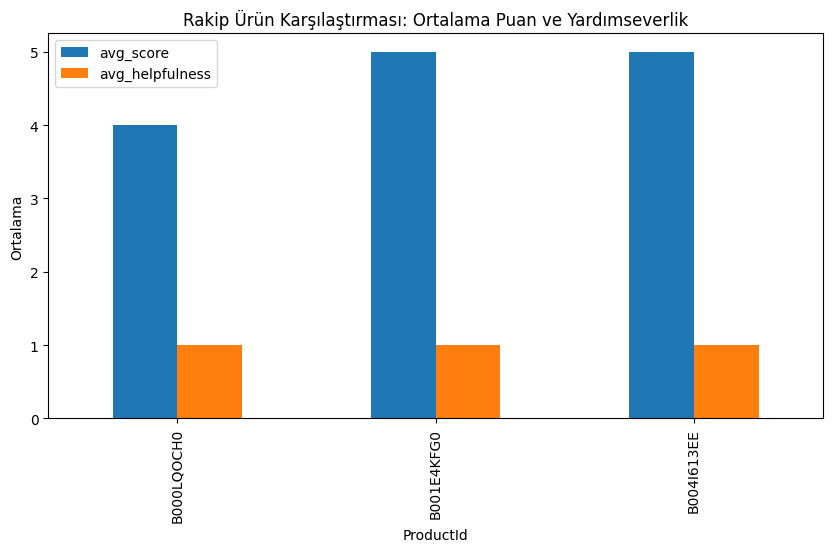

In [75]:
# Rakip Ürün Karşılaştırması: Ortalama Puan ve Yardımseverlik Görselleştirmesi

product_stats.set_index('ProductId')[['avg_score','avg_helpfulness']].plot(kind='bar', figsize=(10,5))
plt.title('Rakip Ürün Karşılaştırması: Ortalama Puan ve Yardımseverlik')
plt.ylabel('Ortalama')
plt.show()


In [82]:
# Olumsuz Yorumlarda En Sık Kullanılan Kelime ve Kelime Çiftlerini Analiz Etme

neg_reviews = df[df['Score'] <= 2]['Text'].astype(str)

# Özel stopword listesi
custom_stopwords = list(text.ENGLISH_STOP_WORDS.union([
    'br','like','just','don','really','time','tried','bought',
    'amazon','product','food','good','tea','coffee','box','dog'
]))

# CountVectorizer: unigram + bigram
vectorizer = CountVectorizer(stop_words=custom_stopwords, ngram_range=(1,2), min_df=20)

X = vectorizer.fit_transform(neg_reviews.astype(str))  # neg_reviews = 1-2 yıldızlı yorumlar
words = vectorizer.get_feature_names_out()
word_counts = X.sum(axis=0).A1

freq_df = pd.DataFrame({'word': words, 'count': word_counts}).sort_values('count', ascending=False)
print(freq_df.head(20))

          word  count
17887    taste  32120
7152    flavor  20543
2592       buy  15040
5137       did  11136
6125       eat  10751
1293       bad  10593
1838    better  10355
19157      try  10246
19776       ve  10140
1390       bag   9882
20181    water   9780
8105       got   9598
10489   little   9167
11045     make   9065
18663  thought   9015
5219      didn   8960
9955      know   8931
10831     love   8929
8254     great   8905
20260      way   8758


In [83]:
# Örnek konu başlıkları
topics = {
    'Paketleme Sorunu': ['package','broken','damaged','box','wrapped'],
    'Tazelik / Son Kullanma': ['expired','stale','old','spoiled'],
    'Yanlış / Eksik Ürün': ['wrong','missing','incorrect','substitute'],
    'Tat / Lezzet Sorunu': ['taste','flavor','bad','bland','bitter'],
    'Teslimat / Kargo': ['delivery','late','shipping','slow']
}

# Her konu başlığı için frekans sayısı
topic_counts = {}
for topic, keywords in topics.items():
    topic_counts[topic] = freq_df[freq_df['word'].isin(keywords)]['count'].sum()

topic_counts_df = pd.DataFrame(list(topic_counts.items()), columns=['Topic','Count']).sort_values('Count', ascending=False)
print(topic_counts_df)


                    Topic  Count
3     Tat / Lezzet Sorunu  68544
1  Tazelik / Son Kullanma  10732
0        Paketleme Sorunu   8908
4        Teslimat / Kargo   5219
2     Yanlış / Eksik Ürün   4055


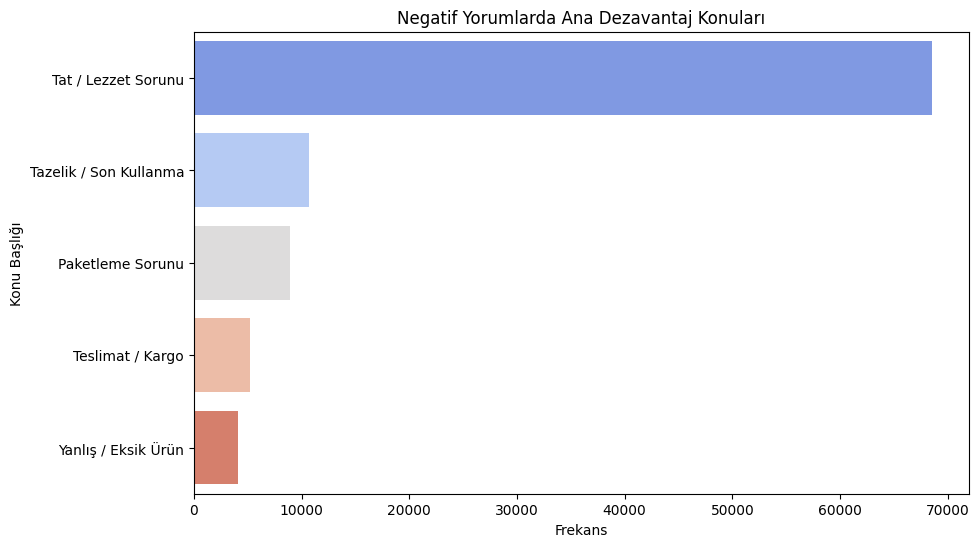

In [84]:
# Negatif Yorumlarda Ana Dezavantaj Konuları Görselleştirmesi

plt.figure(figsize=(10,6))
sns.barplot(x='Count', y='Topic', data=topic_counts_df, palette='coolwarm')
plt.title('Negatif Yorumlarda Ana Dezavantaj Konuları')
plt.xlabel('Frekans')
plt.ylabel('Konu Başlığı')
plt.show()


In [ ]:
# 5 yıldızlı yorumlar
reviews_5 = df[df['Score'] == 5]['Text'].astype(str)

# 1-2 yıldızlı yorumlar
reviews_1_2 = df[df['Score'] <= 2]['Text'].astype(str)


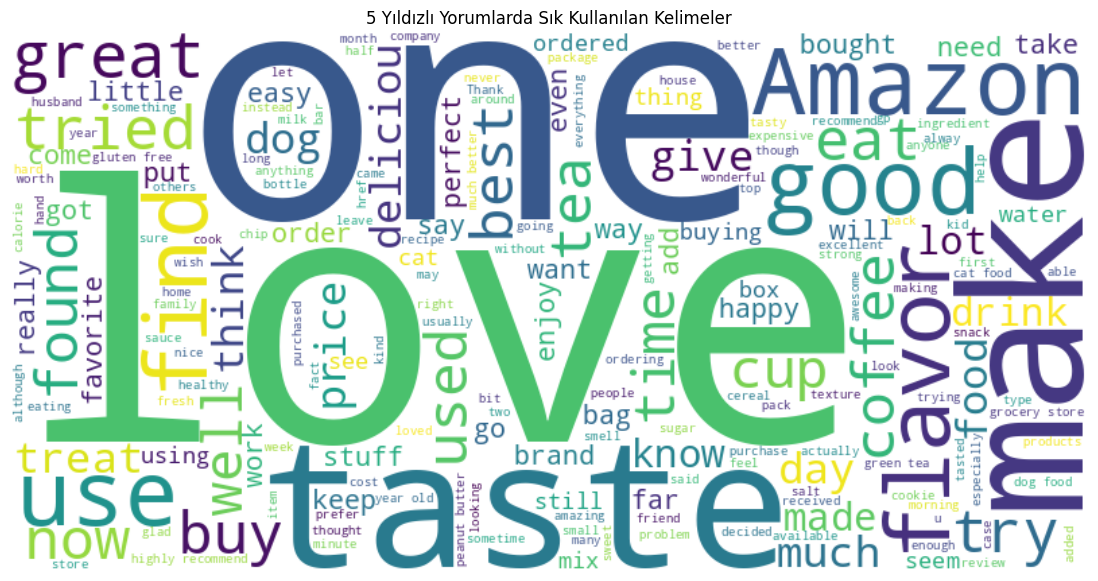

In [ ]:
# WorldCloud Görselleştirmesi

# Özel stopwords listesi: WordCloud'un kendi stopwords + anlamsız kelimeler
custom_stopwords = set(STOPWORDS)
custom_stopwords.update(['br', 'like', 'product'])  # İstenmeyen kelimeleri ekle

# 5 yıldızlı yorumlar
wordcloud_5 = WordCloud(
    width=800, height=400, background_color='white',
    stopwords=custom_stopwords
).generate(' '.join(reviews_5))

plt.figure(figsize=(15,7))
plt.imshow(wordcloud_5, interpolation='bilinear')
plt.axis('off')
plt.title('5 Yıldızlı Yorumlarda Sık Kullanılan Kelimeler')
plt.show()

# 1-2 yıldızlı yorumlar
wordcloud_1_2 = WordCloud(
    width=800, height=400, background_color='white',
    stopwords=custom_stopwords
).generate(' '.join(reviews_1_2))

plt.figure(figsize=(15,7))
plt.imshow(wordcloud_1_2, interpolation='bilinear')
plt.axis('off')
plt.title('1-2 Yıldızlı Yorumlarda Sık Kullanılan Kelimeler')
plt.show()